In [5]:
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
#from keras.engine.sequential import Sequential
#from keras.layers import Dense
from sklearn.svm import SVC
from sklearn.utils import resample
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pyprojroot import here
from sklearn.preprocessing import MinMaxScaler
#from keras.wrappers.scikit_learn import KerasClassifier
import requests
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

def encode_column(col):
    label_encoder = LabelEncoder()

    col = label_encoder.fit_transform(col)

    return col

def intialize_model(model_type, **params):
        if model_type == 'SVM':
            return SVC(**params)
        elif model_type == 'KNN':
            return KNeighborsClassifier(**params)
        elif model_type == 'NN':
            return KerasClassifier(build_fn=create_model, verbose=0)
        elif model_type == 'XG':
            return xgb.XGBClassifier(**params)
        else:
            print("Model type is not recognized.")

def create_model(input_dim=8, hidden_units=12, output_dim=1):
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=input_dim, activation='relu'))
    model.add(Dense(output_dim, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['precision'])
    return model

def tune_model(param_grid, model, x_train, y_train, folds, metric):

    group_kfold = GroupKFold(n_splits=folds)

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=group_kfold, scoring=metric)

    grid_search.fit(x_train, y_train, groups = x_train['Date'])

    return grid_search

def print_grid(grid):
    best_params = grid.best_params_
    best_score = grid.best_score_

    print("The best parameters for the model are " + str(best_params))
    print("The best score for the model is: " + str(best_score))

def plot_testing_size(data):
    training_size_performance = data.groupby('testing_size')['training_score'].max().reset_index()
    testing_size_performance = data.groupby('testing_size')['testing_score'].max().reset_index()
    sns.lineplot(data=training_size_performance, x='testing_size', y='training_score', marker='o', label='Training Score')
    sns.lineplot(data=testing_size_performance, x='testing_size', y='testing_score', marker='o', label='Testing Score')
    
    plt.title('Maximum Score by Training Size')
    plt.legend()
    plt.xlabel('Testing Size')
    plt.ylabel('Best Score')

def plot_metric(data, metric):
    param_performance = data.groupby(metric)['training_score'].max().reset_index()
    sns.lineplot(data=param_performance, x=metric, y='training_score', marker='o')
    
    # Adding title and labels
    plt.title('Maximum Score by Training Size')
    plt.xlabel(metric)
    plt.ylabel('Best Score')

def evaluate_model(model, X_test, y_test, metric):
    
    y_pred = model.predict(X_test)
    
    if metric == 'accuracy':
        return accuracy_score(y_test, y_pred)
    elif metric == 'precision':
        return precision_score(y_test, y_pred, zero_division=1)
    elif metric == 'recall':
        return recall_score(y_test, y_pred)
    elif metric == 'f1':
        return f1_score(y_test, y_pred)

def collect_tuning_results(data, target, model, param_grid, folds, metric):

    results = pd.DataFrame(columns=list(param_grid.keys()) + ['training_score', 'testing_score', 'training_size'])
    
    testing_sizes = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
    
    for testing_size in testing_sizes:

        train_ids, test_ids = train_test_split(data['Date'].unique(), test_size=testing_size, random_state=42)
        train = data[data['Date'].isin(train_ids)]
        test = data[data['Date'].isin(test_ids)]

        x_train = train.drop(target, axis = 1)
        x_test = test.drop(target, axis = 1)
        y_train = train[target]
        y_test = test[target]

        grid = tune_model(param_grid, model, x_train, y_train, folds = folds, metric = metric)
    
        print_grid(grid)
            
        df = pd.DataFrame(grid.cv_results_['params'])
    
        df['training_score'] = grid.cv_results_['mean_test_score']

        df['testing_score'] = evaluate_model(grid.best_estimator_, x_test, y_test, metric)
    
        df['testing_size'] = testing_size
    
        results = pd.concat([results, df], axis=0, ignore_index=True)

    return results


def get_buy_data():
    hist_daily = pd.read_csv("amazon_intraday_24.csv")

    hist_daily['Date'] = pd.to_datetime(hist_daily['Datetime']).dt.date

    hist_daily = hist_daily[hist_daily['Date'] > pd.to_datetime('2024-03-31').date()]
    
    grouped_data = hist_daily.groupby('Date')
    
    hist_daily['highest_next_30'] = grouped_data['Close'].rolling(window=30, min_periods=1).max().reset_index(level=0, drop=True).shift(-30)
    
    hist_daily['Norm_Close_3'] = hist_daily['Close']  / grouped_data['Close'].rolling(window=3, min_periods=1).max().reset_index(level=0, drop=True)
    hist_daily['Norm_Close_5'] = hist_daily['Close']  / grouped_data['Close'].rolling(window=5, min_periods=1).max().reset_index(level=0, drop=True)
    hist_daily['Norm_Close_10'] = hist_daily['Close']  / grouped_data['Close'].rolling(window=10, min_periods=1).max().reset_index(level=0, drop=True)
    hist_daily['Norm_Close_15'] = hist_daily['Close']  / grouped_data['Close'].rolling(window=15, min_periods=1).max().reset_index(level=0, drop=True)
    hist_daily['Norm_Close_20'] = hist_daily['Close']  / grouped_data['Close'].rolling(window=20, min_periods=1).max().reset_index(level=0, drop=True)
    hist_daily['Norm_Close_25'] = hist_daily['Close']  / grouped_data['Close'].rolling(window=25, min_periods=1).max().reset_index(level=0, drop=True)
    hist_daily['Norm_Close_30'] = hist_daily['Close']  / grouped_data['Close'].rolling(window=30, min_periods=1).max().reset_index(level=0, drop=True)
    
    hist_daily['Norm_Volume_3'] = hist_daily['Volume']  / grouped_data['Volume'].rolling(window=3, min_periods=1).max().reset_index(level=0, drop=True)
    hist_daily['Norm_Volume_5'] = hist_daily['Volume']  / grouped_data['Volume'].rolling(window=5, min_periods=1).max().reset_index(level=0, drop=True)
    hist_daily['Norm_Volume_10'] = hist_daily['Volume']  / grouped_data['Volume'].rolling(window=10, min_periods=1).max().reset_index(level=0, drop=True)
    hist_daily['Norm_Volume_15'] = hist_daily['Volume']  / grouped_data['Volume'].rolling(window=15, min_periods=1).max().reset_index(level=0, drop=True)
    hist_daily['Norm_Volume_20'] = hist_daily['Volume']  / grouped_data['Volume'].rolling(window=20, min_periods=1).max().reset_index(level=0, drop=True)
    hist_daily['Norm_Volume_25'] = hist_daily['Volume']  / grouped_data['Volume'].rolling(window=25, min_periods=1).max().reset_index(level=0, drop=True)
    hist_daily['Norm_Volume_30'] = hist_daily['Volume']  / grouped_data['Volume'].rolling(window=30, min_periods=1).max().reset_index(level=0, drop=True)
    hist_daily['pct_change'] = ((hist_daily['highest_next_30'] - hist_daily['Close']) / hist_daily['Close']) * 100
    
    hist_daily['Buy'] = (hist_daily['pct_change'] > 0.4).astype(int)
    
    hist_daily['Date'] = encode_column(hist_daily['Date'])
    
    data = hist_daily.drop(['highest_next_30', 'pct_change', 'Datetime', 'Open', 'High', 'Low', 'Close', 'Volume'], axis = 1).dropna()

    return data

def get_sell_data():
    hist_daily = pd.read_csv("amazon_intraday_24.csv")
    hist_daily['Datetime'] = pd.to_datetime(hist_daily['Datetime'])
    hist_daily['Date'] = pd.to_datetime(hist_daily['Datetime']).dt.date
    hist_daily = hist_daily[hist_daily['Date'] > pd.to_datetime('2024-03-31').date()]

    
    results = []
    
    for i, row in hist_daily.iterrows():
        current_time = row['Datetime']
        close_price = row['Close']
        volume = row['Volume']
        
        sell_window = hist_daily[(hist_daily['Datetime'] > current_time) & (hist_daily['Datetime'] <= current_time + pd.Timedelta(minutes=30))]
        
        if not sell_window.empty:
            sell_window['Gain'] = (sell_window['Close'] - close_price) / close_price * 100
            
            best_sell = sell_window.loc[sell_window['Gain'].idxmax()]
            
            results.append({
                'Datetime': current_time,
                'Sell_Datetime': best_sell['Datetime'],
                'Close': close_price,
                'Volume': volume,
                'Sell_Price': best_sell['Close'],
                'Sell_Volume': best_sell['Volume'],
                'Gain': best_sell['Gain'],
                'Sell': 1 if best_sell['Gain'] > 0 else 0
            })
    
    sell_df = pd.DataFrame(results)
    
    grouped_data = sell_df.groupby('Sell_Datetime')
    
    sell_df['Norm_Close_3'] = sell_df['Close']  / grouped_data['Close'].rolling(window=3, min_periods=1).max().reset_index(level=0, drop=True)
    sell_df['Norm_Close_5'] = sell_df['Close']  / grouped_data['Close'].rolling(window=5, min_periods=1).max().reset_index(level=0, drop=True)
    sell_df['Norm_Close_10'] = sell_df['Close']  / grouped_data['Close'].rolling(window=10, min_periods=1).max().reset_index(level=0, drop=True)
    sell_df['Norm_Close_15'] = sell_df['Close']  / grouped_data['Close'].rolling(window=15, min_periods=1).max().reset_index(level=0, drop=True)
    sell_df['Norm_Close_20'] = sell_df['Close']  / grouped_data['Close'].rolling(window=20, min_periods=1).max().reset_index(level=0, drop=True)
    sell_df['Norm_Close_25'] = sell_df['Close']  / grouped_data['Close'].rolling(window=25, min_periods=1).max().reset_index(level=0, drop=True)
    sell_df['Norm_Close_30'] = sell_df['Close']  / grouped_data['Close'].rolling(window=30, min_periods=1).max().reset_index(level=0, drop=True)
    
    sell_df['Norm_Volume_3'] = sell_df['Volume']  / grouped_data['Volume'].rolling(window=3, min_periods=1).max().reset_index(level=0, drop=True)
    sell_df['Norm_Volume_5'] = sell_df['Volume']  / grouped_data['Volume'].rolling(window=5, min_periods=1).max().reset_index(level=0, drop=True)
    sell_df['Norm_Volume_10'] = sell_df['Volume']  / grouped_data['Volume'].rolling(window=10, min_periods=1).max().reset_index(level=0, drop=True)
    sell_df['Norm_Volume_15'] = sell_df['Volume']  / grouped_data['Volume'].rolling(window=15, min_periods=1).max().reset_index(level=0, drop=True)
    sell_df['Norm_Volume_20'] = sell_df['Volume']  / grouped_data['Volume'].rolling(window=20, min_periods=1).max().reset_index(level=0, drop=True)
    sell_df['Norm_Volume_25'] = sell_df['Volume']  / grouped_data['Volume'].rolling(window=25, min_periods=1).max().reset_index(level=0, drop=True)
    sell_df['Norm_Volume_30'] = sell_df['Volume']  / grouped_data['Volume'].rolling(window=30, min_periods=1).max().reset_index(level=0, drop=True)
    
    sell_df['Date'] = pd.to_datetime(sell_df['Datetime']).dt.date
    
    sell_df['Date'] = encode_column(sell_df['Date'])
    
    sell_data = sell_df.drop(['Datetime', 'Sell_Datetime', 'Close', 'Volume', 'Sell_Price',
           'Sell_Volume', 'Gain'], axis = 1).dropna()

    return sell_data



def downsample_data(data, target):

    down_data = resample(data[data[target] == 0], 
                                       replace=False,    
                                       n_samples=len(data[data[target] == 1]), 
                                       random_state=42)
    
    new_data = pd.concat([data[data[target] == 1], down_data])
    
    return new_data

In [6]:
buy_data = get_buy_data()

In [7]:
buy_data = downsample_data(buy_data, 'Buy')

In [8]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit scaler to data and transform data
scaled_data = scaler.fit_transform(buy_data)

# Replace original values with scaled values
buy_data[:] = scaled_data

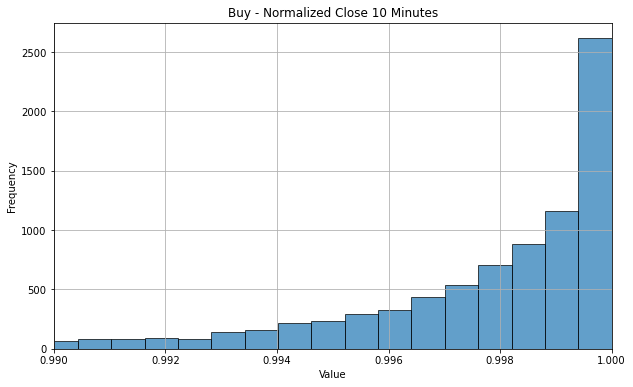

In [9]:
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(buy_data[(buy_data['Norm_Close_10'] > 0.97) & (buy_data['Norm_Close_10'] < 1.03)]['Norm_Close_10'], bins=50, edgecolor='k', alpha=0.7)
plt.title('Buy - Normalized Close 10 Minutes')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.xlim(0.99, 1)  # Set the x-axis limits

plt.savefig('Buy_Norm_Close_10.png')

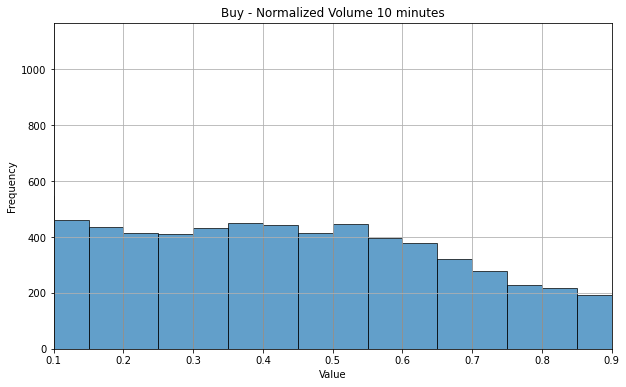

In [10]:
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(buy_data['Norm_Volume_10'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Buy - Normalized Volume 10 minutes')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.xlim(0.1, 0.9)  # Set the x-axis limits

plt.savefig('Buy_Norm_Volume_10.png')

In [ ]:
sell_data = get_sell_data()

<ipython-input-5-a83cea1d292e>:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sell_window['Gain'] = (sell_window['Close'] - close_price) / close_price * 100
<ipython-input-5-a83cea1d292e>:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sell_window['Gain'] = (sell_window['Close'] - close_price) / close_price * 100
<ipython-input-5-a83cea1d292e>:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [ ]:
sell_data = downsample_data(sell_data, 'Sell')

In [ ]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit scaler to data and transform data
scaled_data = scaler.fit_transform(sell_data)

# Replace original values with scaled values
sell_data[:] = scaled_data

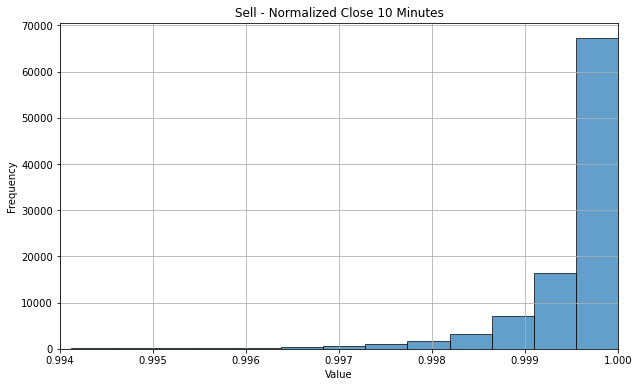

In [1097]:
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(sell_data[(sell_data['Norm_Close_10'] > 0.97) & (sell_data['Norm_Close_10'] < 1.03)]['Norm_Close_10'], bins=50, edgecolor='k', alpha=0.7)
plt.title('Sell - Normalized Close 10 Minutes')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.xlim(0.994, 1)  # Set the x-axis limits

plt.savefig('Sell_Norm_Close_10.png')


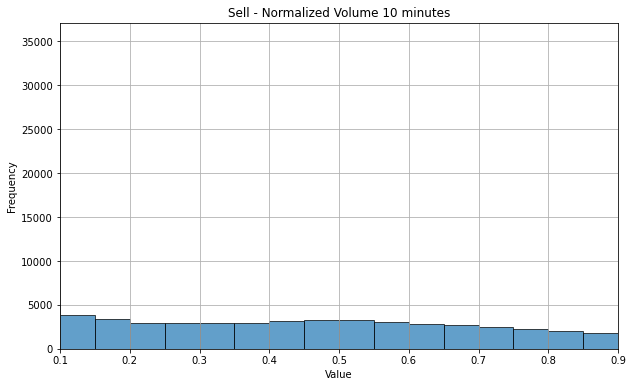

In [1104]:
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(sell_data['Norm_Volume_10'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Sell - Normalized Volume 10 minutes')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.xlim(0.1, 0.9)  # Set the x-axis limits

plt.savefig('Sell_Norm_Volume_10.png')

In [40]:
# Define the parameter grid
param_grid = {
    'kernel': ['rbf', 'linear'],
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.05]
}

In [41]:
model = intialize_model('SVM')

In [43]:
svm_buy_results = collect_tuning_results(buy_data, 'Buy', model, param_grid, 4, 'precision')

The best parameters for the model are {'C': 10, 'gamma': 0.05, 'kernel': 'rbf'}
The best score for the model is: 0.5778721564583326
The best parameters for the model are {'C': 10, 'gamma': 0.05, 'kernel': 'rbf'}
The best score for the model is: 0.6609783885017539
The best parameters for the model are {'C': 10, 'gamma': 0.05, 'kernel': 'rbf'}
The best score for the model is: 0.6282278351680359
The best parameters for the model are {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}
The best score for the model is: 0.6273395868663444
The best parameters for the model are {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}
The best score for the model is: 0.6411060048815833


C:\Users\Cole\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The best parameters for the model are {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}
The best score for the model is: 0.628337843664868


C:\Users\Cole\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Cole\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The best parameters for the model are {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}
The best score for the model is: 0.6326178695688726


C:\Users\Cole\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The best parameters for the model are {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}
The best score for the model is: 0.6423887725885471
The best parameters for the model are {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}
The best score for the model is: 0.6360041423127284


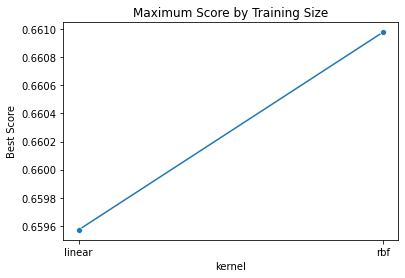

In [49]:
plot_metric(svm_buy_results, 'kernel')

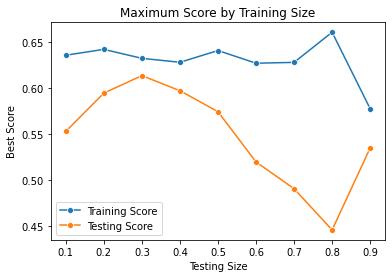

In [46]:
plot_testing_size(svm_buy_results)

In [12]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
}

model = intialize_model('XG')

In [13]:
buy_results = collect_tuning_results(buy_data, 'Buy', model, param_grid, 5, 'precision')

The best parameters for the model are {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
The best score for the model is: 0.6529324817374891
The best parameters for the model are {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400}
The best score for the model is: 0.6557265930152802
The best parameters for the model are {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
The best score for the model is: 0.677400214310869
The best parameters for the model are {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
The best score for the model is: 0.6909902389211753
The best parameters for the model are {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
The best score for the model is: 0.6909619473831912
The best parameters for the model are {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400}
The best score for the model is: 0.6730028299114261
The best parameters for the model are {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}

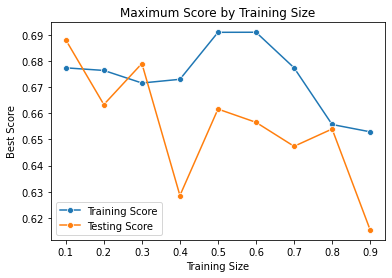

In [16]:
plot_testing_size(buy_results)

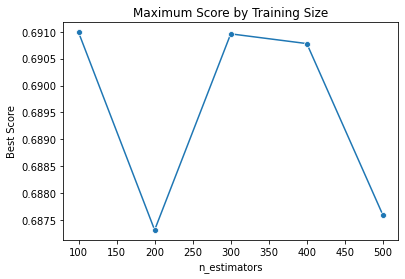

In [15]:
plot_metric(buy_results, 'n_estimators')

In [ ]:
sell_data = get_sell_data()

In [ ]:
sell_results = collect_tuning_results(sell_data, 'Sell', model, param_grid, 5, 'precision')

In [52]:
param_grid = {
    'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'weights': ['uniform', 'distance']
}

model = intialize_model('KNN')

In [53]:
knn_results = collect_tuning_results(buy_data, 'Buy', model, param_grid, 4, 'precision')

The best parameters for the model are {'n_neighbors': 6, 'weights': 'uniform'}
The best score for the model is: 0.5629952880702506
The best parameters for the model are {'n_neighbors': 4, 'weights': 'uniform'}
The best score for the model is: 0.7088042619882137
The best parameters for the model are {'n_neighbors': 6, 'weights': 'uniform'}
The best score for the model is: 0.6920280805873493
The best parameters for the model are {'n_neighbors': 8, 'weights': 'uniform'}
The best score for the model is: 0.6744705592772311
The best parameters for the model are {'n_neighbors': 12, 'weights': 'uniform'}
The best score for the model is: 0.6439576436630928
The best parameters for the model are {'n_neighbors': 12, 'weights': 'uniform'}
The best score for the model is: 0.6159817844800602
The best parameters for the model are {'n_neighbors': 4, 'weights': 'uniform'}
The best score for the model is: 0.5857692144206211
The best parameters for the model are {'n_neighbors': 8, 'weights': 'uniform'}
Th

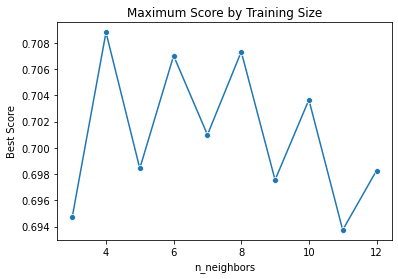

In [54]:
plot_metric(knn_results, 'n_neighbors')

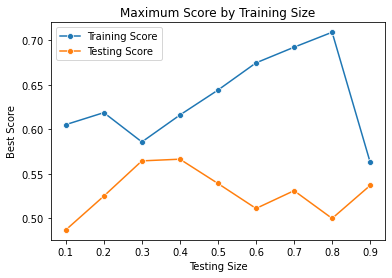

In [55]:
plot_testing_size(knn_results)

In [ ]:
# Define the parameter grid
param_grid = {
    'hidden_units': [8, 12, 16],
    'batch_size': [10, 20, 40],
    'epochs': [10, 50, 100]
}

model = intialize_model('NN')

In [ ]:
results = collect_tuning_results(data, 'Sell', model, param_grid, 5, 'precision')